# `Setup`

This notebook is built to for performing cross validation training for models to evaluate dataset split effects

### Library Import

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
import csv
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset
import warnings
warnings.filterwarnings('ignore')

# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


### Setting seed

In [282]:
# Setting seed
def set_seed (seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    
set_seed(42)

# `Helpers`

### `Split Generator`

In [271]:
def cross_validation_generator(config:dict):
    """Function for generating cross validation splits for our dataset"""
    # Seed for reproducability
    seed = 42
    
    # Extract all data (excl. holdout data for later use)
    data = StateFarmDataset(config).metadata[['subject','target']]
    
    # Generate subject counts for our dataset
    subjects_count = data.groupby('subject').count().reset_index().rename(columns={'target':'counts'}).sort_values('counts', ascending=False)
    
    # Shuffle around
    subjects_count = subjects_count.sample(frac=1, random_state = seed).reset_index(drop=True)
    
    
    # Extract subjects for Val + Test
    cv_split = 1
    subject_split = pd.DataFrame(columns=['subject','split', 'cv_round'])
    
    # Looping through subjects - ensuring subjects are only once in either val or test
    for i in range(0, 20, 4):
        # Subjects per test and val split
        num_subjects = 2
        
        # Lower and upper index bound for test split
        test_lower = i
        test_upper = test_lower + num_subjects
        
        # Lower and upper index bound for val split
        val_lower = test_upper
        val_upper = val_lower + num_subjects

        # Extracting Test Subjects
        test_subjects = subjects_count.iloc[test_lower:test_upper].subject.to_list()
        subject_split = subject_split.append(pd.DataFrame({'subject':test_subjects, 'split':'test', 'cv_round':cv_split}), ignore_index=True)

        # Extracting Validation Subjects
        val_subjects = subjects_count.iloc[val_lower:val_upper].subject.to_list()
        subject_split = subject_split.append(pd.DataFrame({'subject':val_subjects, 'split':'val', 'cv_round':cv_split}), ignore_index=True)
        

        # Add 1 to cv_split
        cv_split += 1
    return subject_split

In [272]:
# Config file
config = load_config(eval(os.environ["COLAB"]))

# Generating cross validation splits
split = cross_validation_generator(config)

### `Training Helpers`

In [273]:
def visualize_training(history, num_epochs=50):
    """Function for visualizing training performance"""
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [307]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [352]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    model.eval()
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    return (test_acc / len(dataloader)), images, classes, predictions, predictions_argmax

In [353]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [370]:
def save_model(model, model_name, cv_fold, epoch):
    """Function for saving model during training"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_cv_fold_{cv_fold}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')
    return file

In [371]:
def write_csv(val_subjects, test_subjects, model_name, cv_fold, val_accuracy, val_loss, test_accuracy, epoch, total_training, train_size, val_size, test_size, timestamp, file_name):
    """Function for writing csv file with results from each cross validation split"""
    # Model name, with path
    file = f'{model_name}_{timestamp}_CV_splits.csv'
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name, file))):
        write_type = 'w'
    else:
        write_type = 'a'

    with open(os.path.join(os.path.join(config['outputs']['path'], model_name, file)), write_type, newline='') as file:
        if write_type == 'w':
            writer = csv.writer(file)
            writer.writerow(["cv_fold", "validation_subjects", "test_subjects", "val_accuracy", "val_loss", "test_accuracy", "epoch", "timestamp", "total_training_time", "train_size", "val_size", "test_size", "file_name"])
            writer.writerow([cv_fold, val_subjects, test_subjects, val_accuracy, val_loss, test_accuracy, epoch, timestamp, total_training,train_size, val_size, test_size, file_name])
        else:
            writer = csv.writer(file)
            writer.writerow([cv_fold, val_subjects, test_subjects, val_accuracy, val_loss, test_accuracy, epoch, timestamp, total_training,train_size, val_size, test_size, file_name])

In [372]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [373]:
def train(model, train_dataloader, validation_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name, val_subjects, test_subjects, cv_fold, train_size, val_size, test_size, timestamp):
    """Model training method"""
    
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()

    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} & CV Fold {cv_fold} of 5 started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Perform forward + backwards pass
        model.train()
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Compute validation loss and accuracy
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        # Print epoch results
        print(f"Epoch {epoch+1} of {epochs} & CV {cv_fold} of 5 ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        #### Intermediate best models not saved - only last version #### 
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping Applied")
            print(f'Computing Accuracy for Test')
            test_output = test(model, test_dataloader, device)
            print(f'Test Accuracy: {round(test_output[0], 4)}')
            print('Saving final model, with loss: ', val_loss)
            file_name = save_model(model=model, model_name=model_name, cv_fold=cv_fold, epoch=epoch)
            total_training_end = time.time()
            minutes, seconds = divmod(total_training_end-total_training_start, 60)
            write_csv(val_subjects=val_subjects, 
                       test_subjects=test_subjects, 
                       model_name=model_name, 
                       cv_fold=cv_fold, 
                       val_accuracy=val_acc, 
                       test_accuracy=test_output[0], 
                       val_loss=val_loss, 
                       epoch=epoch+1,
                       total_training = f'{round(minutes)}:{round(seconds)}',
                       train_size=train_size,
                       val_size=val_size,
                       test_size=test_size,
                       timestamp=timestamp,
                       file_name=file_name)
            
            visualize_training(history, epoch+1)
            break
    
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

# `Model`

In [374]:
# Convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channesl, out_channls, kernel_size = 3, stride=1, pool_kernel = 2, dropout_rate = .2, padding=1, skip_last_dropout=False):
        super(ConvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channesl,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding),
            nn.SELU(True),
            nn.BatchNorm2d(out_channls),
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=out_channls,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding),
            nn.SELU(True),
            nn.BatchNorm2d(out_channls),
            nn.MaxPool2d(kernel_size = pool_kernel),
            nn.Dropout(dropout_rate) if not skip_last_dropout else nn.Identity())

    def forward(self, x):
        return self.main(x)

# Fully Connected Dense Block
class Dense(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate):
        super(Dense, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(True),
            nn.BatchNorm1d(out_features),
            nn.Dropout(dropout_rate),
        )
    
    def forward(self, x):
        return self.main(x)
    

In [375]:
# Smallest version
class VGG_Small(torch.nn.Module):
    def __init__(self, filters = 32, num_classes = 10, kernel_size = 3,  stride = 1, in_channels = 3, pool_kernel_size = 2, padding=1):
        super(VGG_Small, self).__init__()
        # First Convolution Block
        self.main = nn.Sequential(
            ConvBlock(in_channesl=in_channels, out_channls=filters, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.25),
            ConvBlock(in_channesl=filters, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            ConvBlock(in_channesl=filters*2, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            nn.Flatten(),   
            Dense(in_features=3072, out_features=128, dropout_rate=.3), # img size L = 52224 # Old small 12288, 3 channels medium sized input images 6144 - Img size L with stride 2 = 26112
            nn.Linear(in_features=128, out_features=num_classes)) # img size L = 52224 # Old small 12288

    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.main(x)
        return x

# `Data Augmentations`

In [376]:
img_size_L = (168, 224)
img_size_M = (93, 124)
img_size_S = (48, 64)

# IMG Transformations
augmentations = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25),
    v2.RandomResizedCrop(img_size_S, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize(img_size_S, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

# `Training`


In [364]:
# General Hyperparameters
MODEL_NAME = 'TinyVgg_500k'
batch_size = 32
epochs = 50
seed = 42
history = dict()
TIMESTAMP = dt.datetime.now().strftime('%Y%m%d_%H%M%S')

Starting Training with CV Fold 1 of 5

Epoch 1 of 50 & CV Fold 1 of 5 started...
Epoch 1 of 50 - Early stopping Applied
Computing Accuracy for Test
Test Accuracy: 0.1068


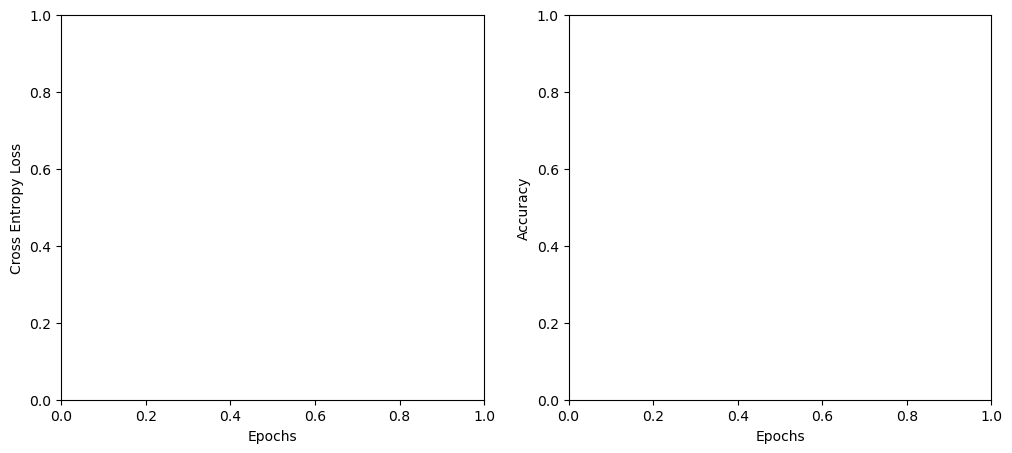

Total training time: 0:6
Starting Training with CV Fold 2 of 5

Epoch 1 of 50 & CV Fold 2 of 5 started...
Epoch 1 of 50 - Early stopping Applied
Computing Accuracy for Test
Test Accuracy: 0.1042


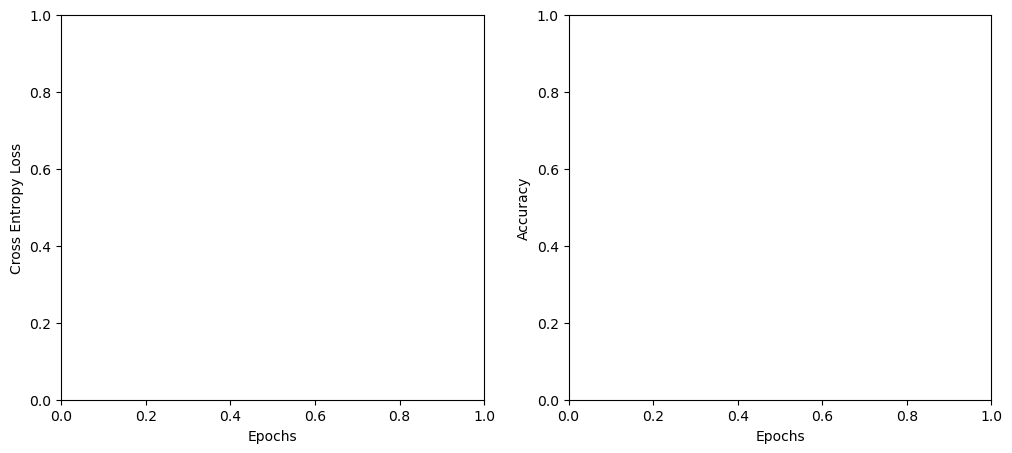

Total training time: 0:5
Starting Training with CV Fold 3 of 5

Epoch 1 of 50 & CV Fold 3 of 5 started...
Epoch 1 of 50 - Early stopping Applied
Computing Accuracy for Test
Test Accuracy: 0.0866


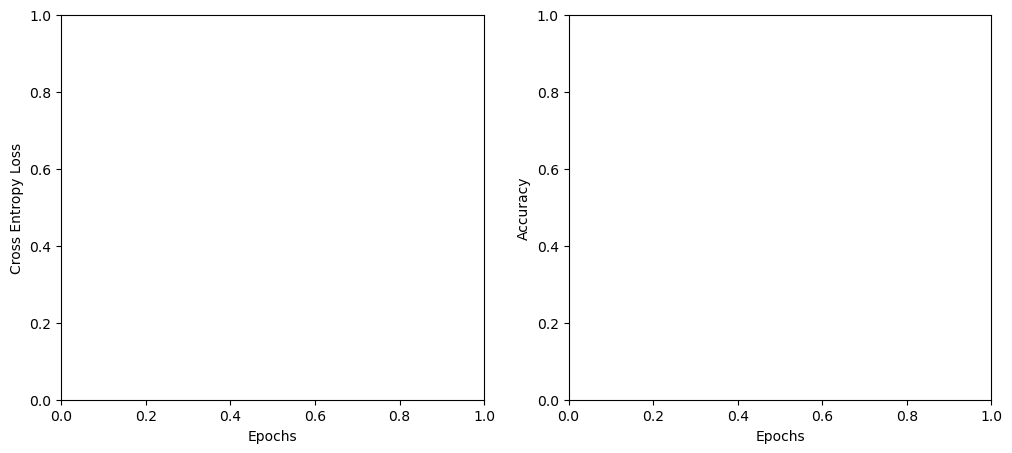

Total training time: 0:5
Starting Training with CV Fold 4 of 5

Epoch 1 of 50 & CV Fold 4 of 5 started...
Epoch 1 of 50 - Early stopping Applied
Computing Accuracy for Test
Test Accuracy: 0.101


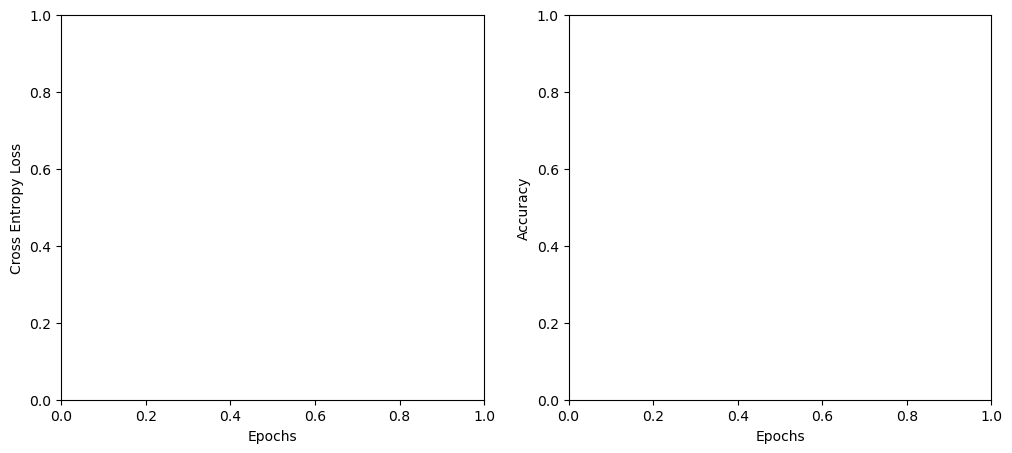

Total training time: 0:4
Starting Training with CV Fold 5 of 5

Epoch 1 of 50 & CV Fold 5 of 5 started...
Epoch 1 of 50 - Early stopping Applied
Computing Accuracy for Test
Test Accuracy: 0.0875


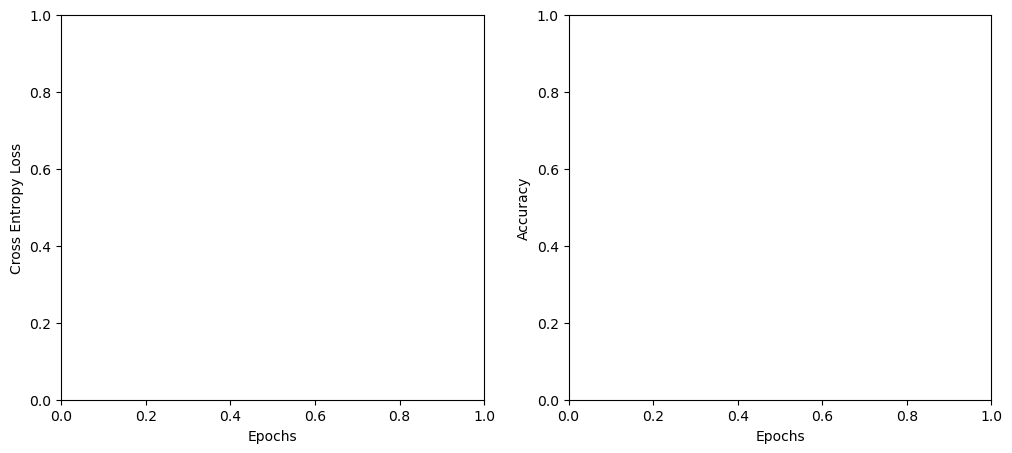

Total training time: 0:3


In [367]:
# Loop Through Splits
for x in split.cv_round.unique():
    # Print CV Fold
    print(f'Starting Training with CV Fold {x} of 5')
    
    # Extracting Split Data
    split_data = split[split.cv_round == x]
    
    # Extracting Val and Test Subjects
    val_subjects = split_data[split_data.split == 'val'].subject.to_list()
    test_subjects = split_data[split_data.split == 'test'].subject.to_list()
    
    # Generating Datasets
    train_data = StateFarmDataset(config, split='train', transform=augmentations['train'], target_transform=target_transform, validation_subjects = val_subjects + test_subjects)   
    val_data = StateFarmDataset(config, split='val',  transform=augmentations['val+test'], target_transform=target_transform, validation_subjects = val_subjects)   
    test_data = StateFarmDataset(config, split='val',  transform=augmentations['val+test'], target_transform=target_transform, validation_subjects = test_subjects)   
    
    
    # Creating new data loaders
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    # Setting up model
    model = VGG_Small(num_classes = 10, in_channels=3)
    model = model.to(device)
    
    
    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

    # Setup scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           'min',
                                                           factor=.1,
                                                           patience=5,
                                                           min_lr=1e-7,
                                                           verbose=True)
    
    early_stopping = EarlyStopper(patience=5, min_delta=.03)

    # results
    results = train(model=model,
                    train_dataloader=train_dataloader,
                    validation_dataloader=val_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device,
                    scheduler=scheduler,
                    early_stopping=early_stopping,
                    model_name=MODEL_NAME,
                    val_subjects=val_subjects,
                    test_subjects=test_subjects,
                    cv_fold=x,
                    train_size=len(train_data),
                    val_size=len(val_data),
                    test_size=len(test_data),
                    timestamp=TIMESTAMP)
    
    # Save results
    history[f'cv_fold_{x}'] = results

### Testing on Test Images

In [ ]:
test_predictions = test(model=model,
                        dataloader=test_dataloader,
                        device=device)

In [ ]:
best_model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10).to(device)
best_model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/EfficientNet_b0_AdamW/EfficientNet_b0_AdamW_20231204_093524_epoch_5.pt'))

In [ ]:
best_predictions = test(model=best_model,
                        dataloader=test_dataloader,
                        device=device)